In [1]:
import collections
import pandas
import scanpy
import scipy
from pathlib import Path
import sys
from urllib import parse
from matplotlib import pyplot
from matplotlib import cm
import loompy
import numpy
import anndata
import scanpy
import upsetplot

from common import (
    scanpy_load_solo_mtx, 
    scanpy_load_alevin_mtx, 
    scanpy_load_kallisto_gene_mtx, 
    load_barcode_list,
    build_anndata,
    plot_retained_barcodes,
)

In [2]:
project_dir = Path('~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/').expanduser()
genome_dir = project_dir / 'genome' / 'mm10-M21-male'
analysis_dir = project_dir / 'ENCSR874BOF_e10_5_limb'

In [3]:
cellranger_raw = scanpy.read_10x_mtx(
    analysis_dir / 'ENCSR874BOF-10x-e10_5-count-cells10000/outs/raw_feature_bc_matrix',
    var_names='gene_ids'
)
cellranger_raw.obs["counts"] = cellranger_raw.X.sum(axis=1)
cellranger_raw.obs["ngenes"] = numpy.array((cellranger_raw.X > 0).sum(axis=1))

cellranger_raw.obs_names = [x[:-2] for x in cellranger_raw.obs_names]
cellranger_raw.shape

(737280, 81881)

In [4]:
cellranger_filtered = scanpy.read_10x_mtx(
    analysis_dir / 'ENCSR874BOF-10x-e10_5-count-cells10000/outs/filtered_feature_bc_matrix',
    var_names='gene_ids'
)
cellranger_filtered.obs["counts"] = cellranger_filtered.X.sum(axis=1)
cellranger_filtered.obs["ngenes"] = numpy.array((cellranger_filtered.X > 0).sum(axis=1))

cellranger_filtered.obs_names = [x[:-2] for x in cellranger_filtered.obs_names]
cellranger_filtered.shape

(7203, 81881)

In [5]:
solo_raw = scanpy_load_solo_mtx(analysis_dir / 'diane_star_solo', mode='raw')
solo_raw.shape

(737280, 81881)

In [6]:
solo_filtered = scanpy.read_h5ad(analysis_dir / 'solo_filtered.sparse.h5ad')
solo_filtered.obs["counts"] = solo_filtered.X.sum(axis=1)
solo_filtered.obs["ngenes"] = numpy.array((solo_filtered.X > 0).sum(axis=1))
solo_filtered.shape

(6287, 81881)

In [7]:
kallisto_raw = scanpy_load_kallisto_gene_mtx(analysis_dir / 'kallisto' / 'genecount')
kallisto_raw.shape

(584570, 81881)

In [8]:
kallisto_filtered_barcodes = load_barcode_list(analysis_dir / 'kallisto' / 'filtered-barcodes.txt')
kallisto_filtered = kallisto_raw[kallisto_filtered_barcodes].copy()
kallisto_filtered.shape

(7874, 81881)

In [9]:
kallisto_em_raw = scanpy_load_kallisto_gene_mtx(analysis_dir / 'kallisto_em' / 'genecount')
kallisto_em_raw.shape

(584570, 81881)

In [10]:
kallisto_em_filtered_barcodes = load_barcode_list(analysis_dir / 'kallisto_em' / 'filtered-barcodes.txt')
kallisto_em_filtered = kallisto_em_raw[kallisto_em_filtered_barcodes].copy()
kallisto_em_filtered.shape

(7874, 81881)

In [11]:
alevin_barcodes = load_barcode_list(analysis_dir / 'alevin_output_encode_R1_R2' / 'alevin' / 'whitelist.txt' )
alevin = scanpy_load_alevin_mtx(analysis_dir / 'alevin_output_encode_R1_R2')
alevin.shape

(7302, 72301)

In [12]:
alevin_filtered = alevin[alevin_barcodes].copy()
alevin_filtered.shape

(5902, 72301)

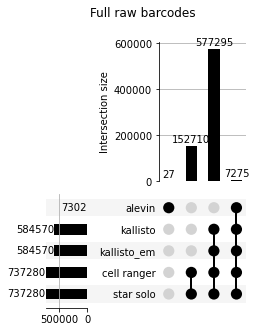

In [13]:
upset_contents = {
    'cell ranger': cellranger_raw.obs_names,
    'star solo': solo_raw.obs_names,
    'kallisto': kallisto_raw.obs_names,
    'kallisto_em': kallisto_em_raw.obs_names,
    'alevin': alevin.obs_names,
    'alevin filtered': alevin_decoy_barcodes,
}

for alg in upset_contents:
    if len(upset_contents[alg]) != len(set(upset_contents[alg])):
        print(alg)

upset_gene_contents = upsetplot.from_contents(upset_contents)

f = pyplot.figure()
upsetplot.plot(upset_gene_contents, fig=f, show_counts=True)
f.suptitle('ENCODE annotation all barcodes')
pass

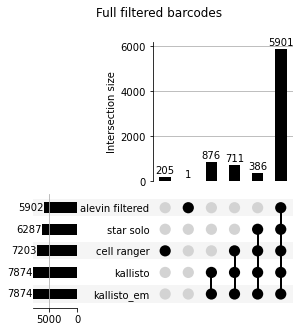

In [14]:
upset_contents = {
    'cell ranger': cellranger_filtered.obs_names,
    'star solo': solo_filtered.obs_names,
    'kallisto': kallisto_filtered_barcodes,
    'kallisto_em': kallisto_em_filtered_barcodes,
    'alevin': alevin.obs_names,
    'alevin filtered': alevin_barcodes,
}

for alg in upset_contents:
    if len(upset_contents[alg]) != len(set(upset_contents[alg])):
        print(alg)

upset_gene_contents = upsetplot.from_contents(upset_contents)

f = pyplot.figure()
upsetplot.plot(upset_gene_contents, fig=f, show_counts=True)
f.suptitle('ENCODE annotation with most filtered barcodes')
pass

In [15]:
colors = { x: cm.tab10(i) for i, x in enumerate([
    'alevin filtered',
    'alevin',
    'alevin decoy',
    'cell ranger',
    'kallisto',
    'kallisto_em',
    'star solo',
])}

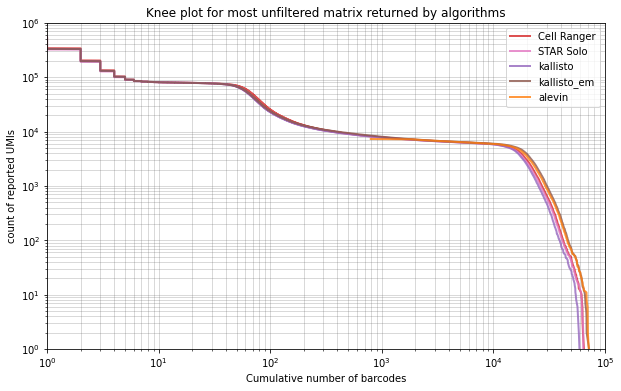

In [16]:
f = pyplot.figure(figsize=(10,6))
ax = f.add_subplot(1,1,1)

alpha = 0.8
gridalpha = 0.5
#max_barcodes = max(cellranger_raw.X.shape[0], solo_raw.X.shape[0], kallisto_raw.X.shape[0], alevin_decoy.X.shape[0], alevin.X.shape[0])
#tenx_ranked_umi[0:np.shape(kallisto.X)[0]], np.arange(np.shape(kallisto.X)[0])

ax.set_title('Knee plot for most unfiltered matrix returned by algorithms')
cellranger_ranked_umi = numpy.sort(numpy.array(cellranger_raw.obs['counts']), axis=None)[::-1]
ax.plot(cellranger_ranked_umi, range(cellranger_ranked_umi.shape[0]), linewidth=2, alpha=alpha, 
        c=colors['cell ranger'],
        label='Cell Ranger')

solo_ranked_umi = numpy.sort(numpy.array(solo_raw.obs['counts']), axis=None)[::-1]
ax.plot(solo_ranked_umi,  range(solo_ranked_umi.shape[0]), linewidth=2, alpha=alpha, 
        c=colors['star solo'],
        label='STAR Solo')

kallisto_ranked_umi = numpy.sort(numpy.array(kallisto_raw.obs['counts']), axis=None)[::-1]
ax.plot(kallisto_ranked_umi,  range(kallisto_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['kallisto'],
        label='kallisto')

kallisto_em_ranked_umi = numpy.sort(numpy.array(kallisto_em_raw.obs['counts']), axis=None)[::-1]
ax.plot(kallisto_em_ranked_umi,  range(kallisto_em_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['kallisto_em'],
        label='kallisto_em')

alevin_ranked_umi = numpy.sort(numpy.array(alevin.obs['counts']), axis=None)[::-1]
ax.plot(alevin_ranked_umi,  range(alevin_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['alevin'],
        label='alevin')

#alevin_ranked_umi = numpy.sort(numpy.array(alevin_decoy.obs['counts']), axis=None)[::-1]
#ax.plot(alevin_ranked_umi, range(alevin_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
#        c=colors['alevin'],
#        label='alevin')

ax.set_xlabel('Cumulative number of barcodes')
ax.set_ylabel('count of reported UMIs')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,1e5)
ax.set_ylim(1,1e6)
ax.grid(color="dimgrey", linestyle="-", linewidth=0.5, which="both", alpha=gridalpha)
ax.legend()
pass

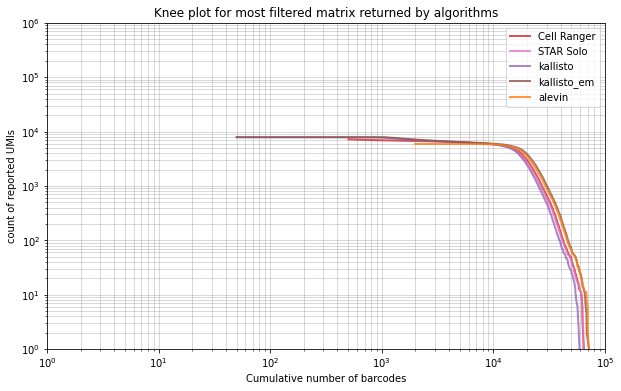

In [17]:
f = pyplot.figure(figsize=(10,6))
ax = f.add_subplot(1,1,1)

alpha = 0.8
gridalpha = 0.5
#max_barcodes = max(cellranger_raw.X.shape[0], solo_raw.X.shape[0], kallisto_raw.X.shape[0], alevin_decoy.X.shape[0], alevin.X.shape[0])
#tenx_ranked_umi[0:np.shape(kallisto.X)[0]], np.arange(np.shape(kallisto.X)[0])

ax.set_title('Knee plot for most filtered matrix returned by algorithms')

cellranger_filtered_ranked_umi = numpy.sort(numpy.array(cellranger_filtered.obs['counts']), axis=None)[::-1]
ax.plot(cellranger_filtered_ranked_umi, range(cellranger_filtered_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['cell ranger'],
        label='Cell Ranger')

solo_filtered_ranked_umi = numpy.sort(numpy.array(solo_filtered.obs['counts']), axis=None)[::-1]
ax.plot(solo_filtered_ranked_umi,  range(solo_filtered_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['star solo'],
        label='STAR Solo')

kallisto_filtered_ranked_umi = numpy.sort(numpy.array(kallisto_filtered.obs['counts']), axis=None)[::-1]
ax.plot(kallisto_filtered_ranked_umi,  range(kallisto_filtered_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['kallisto'],
        label='kallisto')

kallisto_em_filtered_ranked_umi = numpy.sort(numpy.array(kallisto_em_filtered.obs['counts']), axis=None)[::-1]
ax.plot(kallisto_em_filtered_ranked_umi,  range(kallisto_em_filtered_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['kallisto_em'],
        label='kallisto_em')


alevin_filtered_ranked_umi = numpy.sort(numpy.array(alevin_filtered.obs['counts']), axis=None)[::-1]
ax.plot(alevin_filtered_ranked_umi,  range(alevin_filtered_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['alevin'],
        label='alevin')

#alevin_filtered_ranked_umi = numpy.sort(numpy.array(alevin.obs['counts']), axis=None)[::-1]
#ax.plot(alevin_filtered_ranked_umi,  range(alevin_filtered_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
#        c=colors['alevin'],
#        label='alevin')

ax.set_xlabel('Cumulative number of barcodes')
ax.set_ylabel('count of reported UMIs')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,1e5)
ax.set_ylim(1,1e6)
ax.grid(color="dimgrey", linestyle="-", linewidth=0.5, which="both", alpha=gridalpha)
ax.legend()
pass

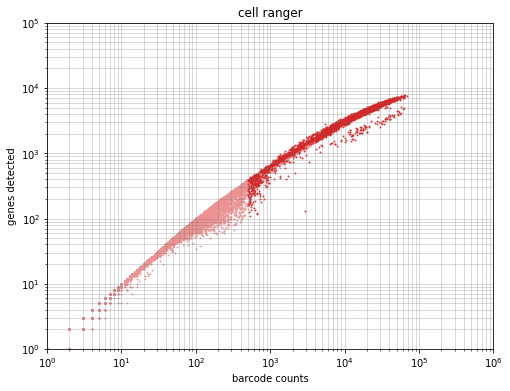

In [18]:
f = plot_retained_barcodes(cellranger_raw, cellranger_filtered, colors, 'cell ranger')
f.savefig(analysis_dir / 'cellranger_retained_barcodes.png')

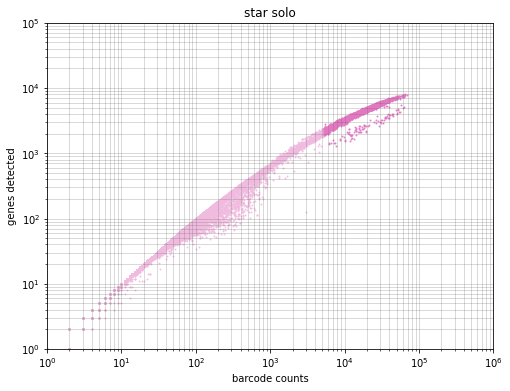

In [19]:
f = plot_retained_barcodes(solo_raw, solo_filtered, colors, 'star solo')
f.savefig(analysis_dir / 'star_solo_retained_barcodes.png')

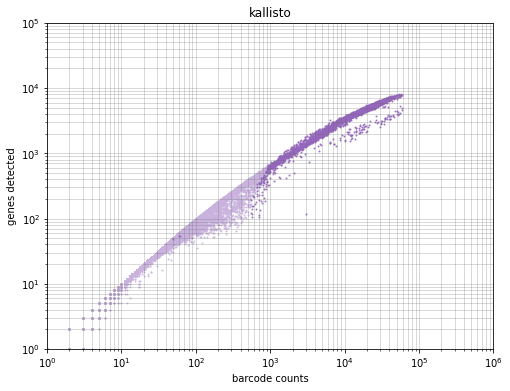

In [20]:
f = plot_retained_barcodes(kallisto_raw, kallisto_filtered, colors, 'kallisto')
f.savefig(analysis_dir / 'kallisto_retained_barcodes.png')

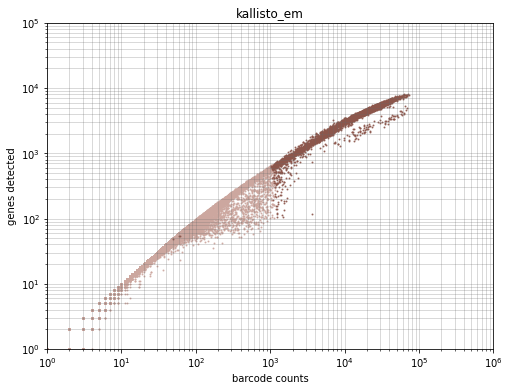

In [21]:
f = plot_retained_barcodes(kallisto_em_raw, kallisto_em_filtered, colors, 'kallisto_em')
f.savefig(analysis_dir / 'kallisto_em_retained_barcodes.png')

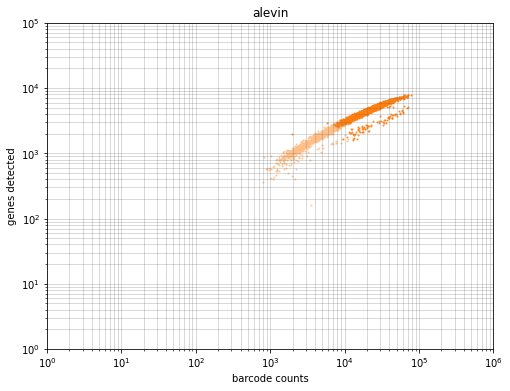

In [22]:
f = plot_retained_barcodes(alevin, alevin_filtered, colors, 'alevin')
f.savefig(analysis_dir / 'alevin_retained_barcodes.png')

# Annotate with gene symbols

In [23]:
cellranger_filtered.var_keys()

['gene_symbols', 'feature_types']

In [24]:
#project_dir = Path('~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/').expanduser()
#genome_dir = project_dir /'genome'/'mm10-M21-male'
genome_dir = Path('~/proj/genome').expanduser() / 'mm10-M21-male'

store = pandas.HDFStore(genome_dir / 'mm10-M21-male.h5')
gtf = store[store.keys()[0]]
store.close()

In [25]:
def add_gene_symbols_to_anndata(adata, gtf, key="gene_id"):
    if key == "gene_id":
        # We have a gene matrixCell
        info = gtf[gtf["type"].isin(["gene", "tRNA"]) | (gtf["source"] == "spikein")]
        info = info.set_index("gene_id")
        feature_type = "gene"
    elif key == "transcript_id":
        info = gtf[(gtf["type"].isin(["transcript", "tRNA"])) | (gtf["source"] == "spikein")]
        info = info.set_index("transcript_id")
        feature_type = "transcript"
    else:
        raise ValueError(
            "Unrecognized key expected gene_id or transcript_id got {}".format(key)
            )
    gene_names = []
    gene_types = []
    for feature in adata.var_names:
        gene_names.append(info.loc[feature, "gene_name"])
        gene_types.append(info.loc[feature, "gene_type"])

    adata.var["gene_symbols"] = gene_names
    adata.var["gene_types"] = gene_types
    adata.uns["feature_type"] = feature_type
    return adata


In [26]:
add_gene_symbols_to_anndata(solo_filtered, gtf)

AnnData object with n_obs × n_vars = 6287 × 81881 
    obs: 'counts', 'ngenes'
    var: 'gene_symbols', 'gene_types'
    uns: 'feature_type'

In [27]:
add_gene_symbols_to_anndata(alevin, gtf)

AnnData object with n_obs × n_vars = 7302 × 72301 
    obs: 'counts', 'ngenes'
    var: 'gene_symbols', 'gene_types'
    uns: 'feature_type'

In [28]:
add_gene_symbols_to_anndata(alevin_filtered, gtf)

AnnData object with n_obs × n_vars = 5902 × 72301 
    obs: 'counts', 'ngenes'
    var: 'gene_symbols', 'gene_types'
    uns: 'feature_type'

In [29]:
add_gene_symbols_to_anndata(kallisto_filtered, gtf)

AnnData object with n_obs × n_vars = 7874 × 81881 
    obs: 'counts', 'ngenes'
    var: 'gene_symbols', 'gene_types'
    uns: 'feature_type'

In [30]:
add_gene_symbols_to_anndata(kallisto_em_filtered, gtf)

AnnData object with n_obs × n_vars = 7874 × 81881 
    obs: 'counts', 'ngenes'
    var: 'gene_symbols', 'gene_types'
    uns: 'feature_type'

# Scanpy top genes detected

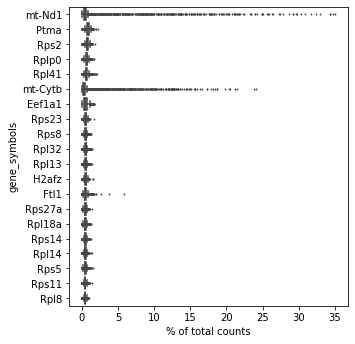

In [31]:
scanpy.pl.highest_expr_genes(cellranger_filtered, n_top=20, gene_symbols='gene_symbols')

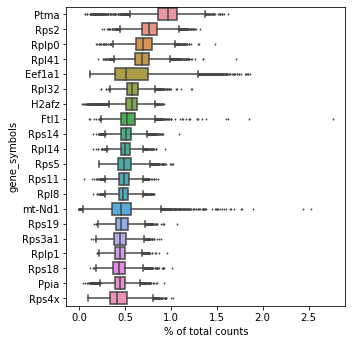

In [32]:
scanpy.pl.highest_expr_genes(solo_filtered, n_top=20, gene_symbols='gene_symbols')

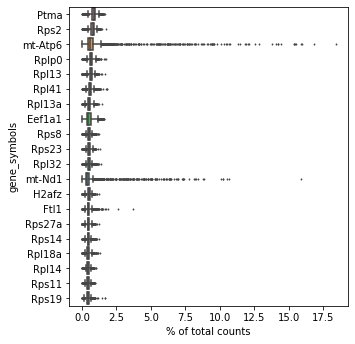

In [33]:
scanpy.pl.highest_expr_genes(alevin, n_top=20, gene_symbols='gene_symbols')

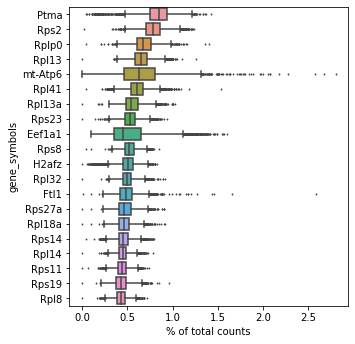

In [34]:
scanpy.pl.highest_expr_genes(alevin_filtered, n_top=20, gene_symbols='gene_symbols')

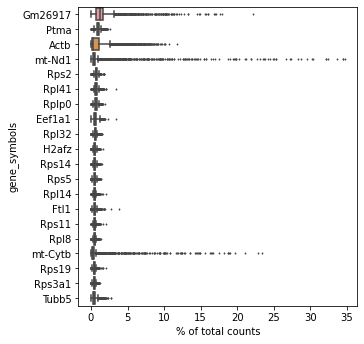

In [35]:
scanpy.pl.highest_expr_genes(kallisto_filtered, n_top=20, gene_symbols='gene_symbols')

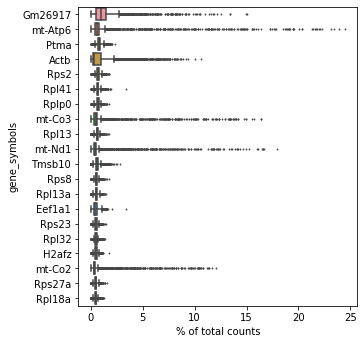

In [36]:
scanpy.pl.highest_expr_genes(kallisto_em_filtered, n_top=20, gene_symbols='gene_symbols')

# Filter low genes

In [37]:
datasets = {
    "cellranger filtered": cellranger_filtered,
    "solo filtered": solo_filtered, 
    "alevin": alevin, 
    "alevin filtered": alevin_filtered, 
    "kallisto filtered": kallisto_filtered,
    "kallisto em filtered": kallisto_em_filtered,
}

Put all the default filtering and data modifications in one place

In [38]:
fraction = .05
for name in datasets:
    adata = datasets[name]
    min_cells = numpy.floor(len(adata.obs_names) * fraction)
    print('Processing {} shape {}. min_cells={}'.format(name, adata.shape, min_cells))
    scanpy.pp.filter_cells(adata, min_genes=200)
    scanpy.pp.filter_genes(adata, min_cells=min_cells)
    print('  new shape {}'.format(adata.shape))


Processing cellranger filtered shape (7203, 81881). min_cells=360.0
  new shape (7180, 10376)
Processing solo filtered shape (6287, 81881). min_cells=314.0
  new shape (6287, 10761)
Processing alevin shape (7302, 72301). min_cells=365.0
  new shape (7301, 10592)
Processing alevin filtered shape (5902, 72301). min_cells=295.0
  new shape (5902, 10922)
Processing kallisto filtered shape (7874, 81881). min_cells=393.0
  new shape (7853, 10805)
Processing kallisto em filtered shape (7874, 81881). min_cells=393.0
  new shape (7853, 10805)


And then separately try generating summary annotations

In [39]:
for name in datasets:
    print('Processing', name)
    adata = datasets[name]

    # annotate the group of mitochondrial genes as 'mt'
    adata.var['mt'] = adata.var['gene_symbols'].fillna('').str.startswith('mt-')  
    scanpy.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)



Processing cellranger filtered
Processing solo filtered
Processing alevin
Processing alevin filtered
Processing kallisto filtered
Processing kallisto em filtered


... storing 'gene_symbols' as categorical
... storing 'feature_types' as categorical


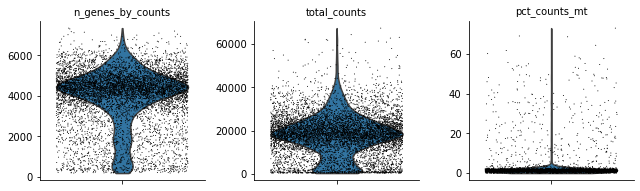

In [42]:
scanpy.pl.violin(
    cellranger_filtered, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True)



... storing 'gene_symbols' as categorical
... storing 'gene_types' as categorical


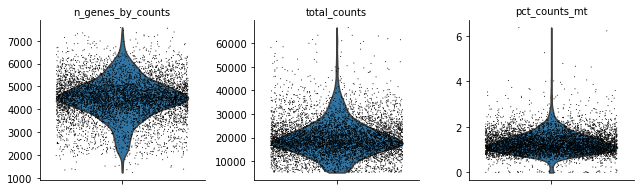

In [43]:
scanpy.pl.violin(
    solo_filtered, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True)



... storing 'gene_symbols' as categorical
... storing 'gene_types' as categorical


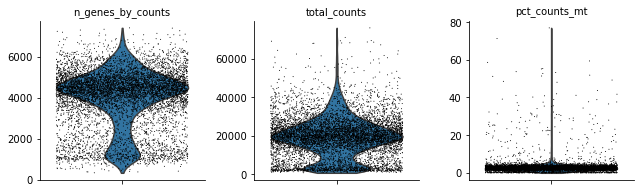

In [44]:
scanpy.pl.violin(
    alevin, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True)



... storing 'gene_symbols' as categorical
... storing 'gene_types' as categorical


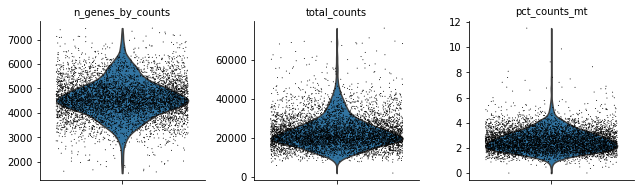

In [45]:
scanpy.pl.violin(
    alevin_filtered, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True)



... storing 'gene_symbols' as categorical
... storing 'gene_types' as categorical


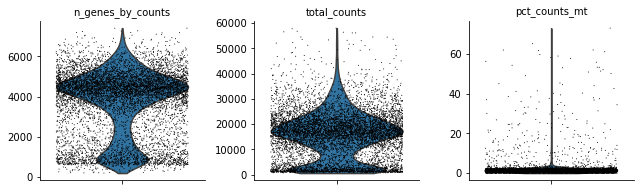

In [46]:
scanpy.pl.violin(
    kallisto_filtered, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True)



... storing 'gene_symbols' as categorical
... storing 'gene_types' as categorical


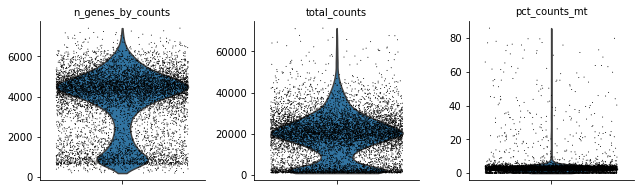

In [47]:
scanpy.pl.violin(
    kallisto_em_filtered, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True)



In [ ]:
for name in datasets:
    adata = datasets[name]
    print(name)
    adata.raw = adata
    adata.X.data = numpy.log2(adata.X.data)
    #scanpy.pp.normalize_total(adata, target_sum=1e5)

In [ ]:
for name in datasets:
    adata = datasets[name]
    print(name)
    scanpy.tl.pca(adata, svd_solver='arpack')
    scanpy.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    scanpy.tl.umap(adata)
    scanpy.tl.leiden(adata)
    scanpy.tl.rank_genes_groups(adata, 'leiden', method='t-test')

In [ ]:
datasets['cellranger filtered'].obs_keys()

In [ ]:
scanpy.pl.pca(datasets['cellranger filtered'], color='leiden')


In [ ]:
scanpy.pl.pca_variance_ratio(datasets['cellranger filtered'], log=True)

In [ ]:
scanpy.pl.umap(datasets['cellranger filtered'], color='leiden')

In [ ]:
scanpy.tl.rank_genes_groups(datasets['cellranger filtered'], 'leiden', method='t-test')
scanpy.pl.rank_genes_groups(datasets['cellranger filtered'], n_genes=25, sharey=False, gene_symbols='gene_symbols')



In [ ]:
scanpy.pl.pca(datasets['solo filtered'], color='leiden')


In [ ]:
scanpy.pl.pca_variance_ratio(datasets['solo filtered'], log=True)

In [ ]:
scanpy.pl.umap(datasets['solo filtered'], color='leiden')

In [ ]:
scanpy.tl.rank_genes_groups(datasets['solo filtered'], 'leiden', method='t-test')
scanpy.pl.rank_genes_groups(datasets['solo filtered'], n_genes=25, sharey=False, gene_symbols='gene_symbols')



In [ ]:
scanpy.pl.pca(datasets['alevin'], color='leiden')


In [ ]:
scanpy.pl.pca_variance_ratio(datasets['alevin'], log=True)

In [ ]:
scanpy.pl.umap(datasets['alevin'], color='leiden')

In [ ]:
scanpy.tl.rank_genes_groups(datasets['alevin'], 'leiden', method='t-test')
scanpy.pl.rank_genes_groups(datasets['alevin'], n_genes=25, sharey=False, gene_symbols='gene_symbols')



In [ ]:
scanpy.pl.pca(datasets['kallisto em filtered'], color='leiden')

In [ ]:
scanpy.pl.pca_variance_ratio(datasets['kallisto em filtered'], log=True)

In [ ]:
scanpy.pl.umap(datasets['kallisto em filtered'], color='leiden')

In [ ]:
scanpy.tl.rank_genes_groups(datasets['kallisto em filtered'], 'leiden', method='t-test')
scanpy.pl.rank_genes_groups(datasets['kallisto em filtered'], n_genes=25, sharey=False, gene_symbols='gene_symbols')



In [ ]:
datasets['kallisto em filtered'].uns['rank_genes_groups'].keys()

In [ ]:
pandas.DataFrame(datasets['kallisto em filtered'].uns['rank_genes_groups']['names']).head(5)

In [ ]:
def plot_confusion(datasets, x_name, y_name):
    names_x = pandas.DataFrame(datasets[x_name].uns['rank_genes_groups']['names'])
    names_y = pandas.DataFrame(datasets[y_name].uns['rank_genes_groups']['names'])
    confusion = numpy.zeros((names_x.shape[1], names_y.shape[1]))
    for cluster_x, members_x in names_x.iteritems():
        for cluster_y, members_y in names_y.iteritems():
            confusion[int(cluster_x), int(cluster_y)] = len(set(members_x).intersection(members_y))


    f = pyplot.figure()
    ax = f.add_subplot(1,1,1)
    im = ax.imshow(confusion, vmin=0, vmax=100)
    cb = pyplot.colorbar(im)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)

In [ ]:
plot_confusion(datasets, 'cellranger filtered', 'solo filtered')

In [ ]:
plot_confusion(datasets, 'cellranger filtered', 'alevin')

In [ ]:
plot_confusion(datasets, 'cellranger filtered', 'kallisto em filtered')

In [ ]:
plot_confusion(datasets, 'solo filtered', 'alevin filtered')

In [ ]:
plot_confusion(datasets, 'solo filtered', 'kallisto em filtered')

In [ ]:
plot_confusion(datasets, 'alevin', 'kallisto em filtered')